In [3]:
# all imports go here
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import train_test_split
from imutils import paths
import numpy as np
import argparse
import imutils
import cv2
import os

In [2]:
def image_to_feature_vector(image, size=(256, 256)):
    # resize the image to a fixed size, then flatten the image into
    # a list of raw pixel intensities
    return cv2.resize(image, size).flatten()

In [3]:
def extract_color_histogram(image, bins=(16, 16, 16)):
    # extract a 3D color histogram from the HSV color space using
    # the supplied number of `bins` per channel
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0, 1, 2], None, bins,
        [0, 256, 0, 256, 0, 256])
 
    # handle normalizing the histogram if we are using OpenCV 2.4.X
    if imutils.is_cv2():
        hist = cv2.normalize(hist)
 
    # otherwise, perform "in place" normalization in OpenCV 3 (I
    # personally hate the way this is done
    else:
        cv2.normalize(hist, hist)
 
    # return the flattened histogram as the feature vector
    return hist.flatten()

In [25]:
# import training data
import pandas as pd
img_path = "D:/invasive_species/train/"
master = pd.read_csv("train_labels.csv")
master.head()
labels = []
file_paths = []
for i in range(len(master)):
    file_paths.append( img_path + str(master.ix[i][0]) +'.jpg' )
    labels.append(master.ix[i][1])

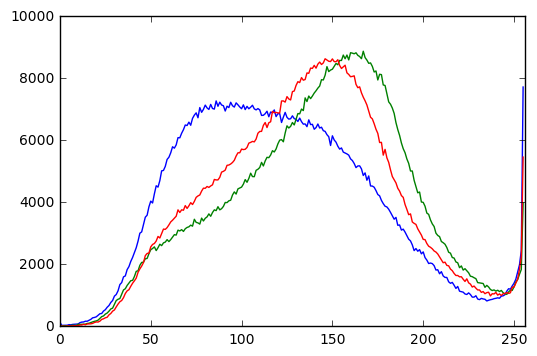

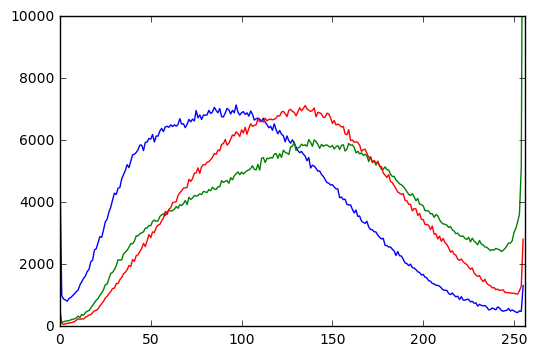

In [42]:
#plot histogram
from matplotlib import pyplot as plt
from matplotlib.pyplot import savefig
from IPython.display import Image as iimage
from PIL import Image
%matplotlib inline
#any two image is chosen at random
img = cv2.imread(file_paths[49])
img2= cv2.imread(file_paths[50])
color = ('b','g','r')

img_to_show1=cv2.resize(img,(0,0), fx=0.25, fy=0.25)
img_to_show2=cv2.resize(img2,(0,0), fx=0.25, fy=0.25)
#convert image from nupmy array
imgg1=Image.fromarray(img_to_show1,'RGB')
imgg2=Image.fromarray(img_to_show2,'RGB')
imgg1.save('image50.png')
imgg2.save('image51.png')
iimage('image50.png')
iimage('image51.png')
#enumerate for r,g,b colors for the images
for i,col in enumerate(color):
    histr = cv2.calcHist([img],[i],None,[256],[0,256])
    histr2= cv2.calcHist([img2],[i],None,[256],[0,256])
    plt.figure(1)
    plt.plot(histr,color = col)
    plt.figure(2)
    plt.plot(histr2,color=col)
    plt.figure(1)
    plt.xlim([0,256])
    plt.ylim([0,10000])
    plt.figure(2)
    plt.xlim([0,256])
    plt.ylim([0,10000])
plt.figure(1)
plt.savefig('rgb_50.png')
plt.figure(2)
plt.savefig('rgb_51.png')


In [5]:
rawImages = []
features = []

In [27]:
#distribution of classes in the training dataset
from matplotlib import pyplot as plt
plt.hist(labels)
plt.title('class distribution')
plt.xlabel('class')
plt.ylabel('frequency')
label=['invasive','not invasive']
plt.xticks(range(0,2),label,rotation=15)
plt.grid()
plt.savefig('class_distribution.png')


In [6]:
for (i, imagePath) in enumerate(file_paths):
    # load the image and extract the class label (assuming that our
    # path as the format: /path/to/dataset/{class}.{image_num}.jpg
    image = cv2.imread(imagePath)
    #label = imagePath.split(os.path.sep)[-1].split(".")[0]
 
    # extract raw pixel intensity "features", followed by a color
    # histogram to characterize the color distribution of the pixels
    # in the image
    pixels = image_to_feature_vector(image)
    hist = extract_color_histogram(image)
 
    # update the raw images, features, and labels matricies,
    # respectively
    rawImages.append(pixels)
    features.append(hist)
    #labels.append(label)
 
    # show an update every 1,000 images
    if i > 0 and i % 1000 == 0:
        print("[INFO] processed {}/{}".format(i, len(file_paths)))

[INFO] processed 1000/2295
[INFO] processed 2000/2295


In [7]:
# check size of images and extracted features 
rawImages = np.array(rawImages)
features = np.array(features)
labels = np.array(labels)
print("[INFO] pixels matrix: {:.2f}MB".format(
	rawImages.nbytes / (1024 * 1000.0)))
print("[INFO] features matrix: {:.2f}MB".format(
	features.nbytes / (1024 * 1000.0)))

[INFO] pixels matrix: 440.64MB
[INFO] features matrix: 36.72MB


In [9]:
#create test train validation sets
(trainRI, testRI, trainRL, testRL) = train_test_split(
	rawImages, labels, test_size=0.25, random_state=42)
(trainFeat, testFeat, trainLabels, testLabels) = train_test_split(
	features, labels, test_size=0.25, random_state=42)

In [10]:
# check knn for raw pixel values on testing validation sets
print("[INFO] evaluating raw pixel accuracy...")
model = KNeighborsClassifier(n_neighbors=5)
model.fit(trainRI, trainRL)
acc = model.score(testRI, testRL)
print("[INFO] raw pixel accuracy: {:.2f}%".format(acc * 100))

[INFO] evaluating raw pixel accuracy...
[INFO] raw pixel accuracy: 53.14%


In [12]:
#check knn for extracted features on testing validation set
print("[INFO] evaluating raw pixel accuracy...")
model2 = KNeighborsClassifier(n_neighbors=5)
model2.fit(trainFeat, trainLabels)
acc2 = model2.score(testFeat, testLabels)
print("[INFO] raw pixel accuracy: {:.2f}%".format(acc2 * 100))
#For feature vector training model

[INFO] evaluating raw pixel accuracy...
[INFO] raw pixel accuracy: 84.84%


In [13]:
#load test images
sample_submission = pd.read_csv("sample_submission.csv")
test_img_path = "D:/invasive_species/test/test/"

test_names = []
test_file_paths = []

for i in range(len(sample_submission)):
    test_names.append(sample_submission.ix[i][0])
    test_file_paths.append( test_img_path + str(int(sample_submission.ix[i][0])) +'.jpg' )
    
test_names = np.array(test_names)

In [14]:
# extract color histogram for test images 
test_rawImages = []
test_features=[]
for (i, imagePath) in enumerate(test_file_paths):
    # load the image and extract the class label (assuming that our
    # path as the format: /path/to/dataset/{class}.{image_num}.jpg
    image = cv2.imread(imagePath)
    #label = imagePath.split(os.path.sep)[-1].split(".")[0]
 
    # extract raw pixel intensity "features", followed by a color
    # histogram to characterize the color distribution of the pixels
    # in the image
    pixels = image_to_feature_vector(image)
    hist = extract_color_histogram(image)
 
    # update the raw images, features, and labels matricies,
    # respectively
    test_rawImages.append(pixels)
    test_features.append(hist)
    #labels.append(label)
 
    # show an update every 1,000 images
    if i > 0 and i % 1000 == 0:
        print("[INFO] processed {}/{}".format(i, len(file_paths)))

[INFO] processed 1000/2295


In [15]:
# convert test images to numpy arrays
test_rawImages=np.array(test_rawImages)
test_features=np.array(test_features)

In [16]:
# check predictions for both raw pixel and extracted feature model
y_pred=model.predict_proba(test_rawImages)
y_pred2=model2.predict_proba(test_features)

In [17]:
# save predictions for images with raw pixel to get kaggle score
sample_submission = pd.read_csv("sample_submission.csv")
for i, name in enumerate(test_names):
    sample_submission.loc[sample_submission['name'] == name, 'invasive'] = max(y_pred[i][0],y_pred[i][1])

sample_submission.to_csv("submit.csv", index=False)

In [18]:
# save predictions for images with extracted features to get kaggle score
sample_submission = pd.read_csv("sample_submission.csv")
for i, name in enumerate(test_names):
    sample_submission.loc[sample_submission['name'] == name, 'invasive'] = max(y_pred2[i][0],y_pred2[i][1])

sample_submission.to_csv("submit2.csv", index=False)